In [1]:
# Base modules

from numpy import load
import numpy as np
from pathlib import Path

# Import os & glob
import os
import glob

# Import plot tools
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import matplotlib.axes as axes
from mpl_toolkits import mplot3d

# Import data analysis tools
from scipy.signal import savgol_filter
from scipy import interpolate
import pandas as pd
from scipy.signal import find_peaks

import seaborn as sns
import matplotlib.gridspec as grid_spec

from statsmodels.graphics import tsaplots
import random

# Import timing
import time
import natsort
import itertools

from sklearn.utils import shuffle

import plotly.express as px
from tqdm.notebook import tqdm

%matplotlib widget

In [2]:
desired_cols = ['fishz', 'fishy', 'fishx','realtime']
# read file
df = pd.read_csv("/home/kkumari/PhD/fish-data/long-term-free-swim/01_T1_1b8cd8200e6211edb285003053fc6914_VR03.csv.gz", usecols=desired_cols)
dfx= df

In [3]:
# #  get all files form folder with keyword 01
# path = "C:/PhD/17010223/long-term-free-swim/"
# all_files = glob.glob(os.path.join(path, "01*.csv.gz"))
# #  concatenate all files
# df = pd.concat((pd.read_csv(f, usecols=desired_cols) for f in all_files), ignore_index=True)
# dfx= dfx.append(df, ignore_index=True)

In [4]:
zs = dfx["fishx"].rolling(window=11, center=True).mean().interpolate(method="pad")
ys = dfx["fishy"].rolling(window=11, center=True).mean().interpolate(method="pad")
xs = dfx["fishz"].rolling(window=11, center=True).mean().interpolate(method="pad")
dx= xs.diff().interpolate(method='bfill')
dy= ys.diff().interpolate(method='bfill')
dz= zs.diff().interpolate(method='bfill')

dfx["dx"] = dx
dfx["dy"] = dy
dfx["dz"] = dz


ddf=dfx

In [5]:
ddfs = ddf.diff(periods=1, axis=0)

steps = np.sqrt(ddfs["fishx"]**2 + ddfs["fishy"]**2 + ddfs["fishz"]**2)
ddfs["steps"] = steps

In [6]:
print('dx, dy, dz and steps quantiles')
print(ddfs['fishx'].quantile(0.999))
print(ddfs['fishy'].quantile(0.999))
print(ddfs['fishz'].quantile(0.999))

dx, dy, dz and steps quantiles
0.004184031676913817
0.005020046985444493
0.0100732000718258


In [7]:
max_stepsize = 0.02 #m : 1.5 body lengths between successive frames

#... see where it happens...
large_steps = ddfs['steps'] > max_stepsize
count_large_steps = np.count_nonzero(large_steps)

print('Number of steps above threshold:')
print(count_large_steps)

Number of steps above threshold:
447


In [8]:
w = 10 #frames (represents half the window for deletion)
selected_columns = ['fishz', 'fishy', 'fishx']

large_step_indices = large_steps[large_steps].index.values

print(large_step_indices)
w = 10

for i in range(0, count_large_steps):
    lsi = large_step_indices[i]
    ddf.loc[lsi-w:lsi+w, selected_columns] = np.nan

[   135    367   9014  17253  18530  18755  18757  18764  18775  18778
  18821  18822  18823  18824  18853  18854  18855  20154  20239  21021
  23695  27990  30352  30671  32073  34909  36537  37814  39926  45292
  45409  45747  45806  46005  46159  46396  46959  46989  50464  50586
  50590  50592  50703  51751  53924  53925  53973  54781  55270  56749
  58414  61371  63123  66768  67432  67517  68865  69075  71460  76848
  77063  77661  79539  80426  82874  83037  86153  88279  89847  90415
  95878  98024  98195 100030 100061 104953 106316 114581 119451 120791
 125622 127808 129499 135377 137358 137439 137854 137873 137969 139026
 140799 141898 147948 150693 157687 157688 157692 157693 157724 165944
 167276 168250 168296 171092 175853 176081 176538 176594 176606 176655
 182775 182780 187784 187998 191038 191097 192263 192291 192347 192348
 193619 196170 196192 197220 197880 197941 198007 199582 199583 199653
 200553 202306 204754 204782 206249 212651 214948 220209 220579 220660
 22070

In [9]:
# cartesian to polar coodinates
def cart2pol(x,y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y,x)
    return(rho, phi)

# cartesian to spherical coordinates
def cart2sph(x,y,z):
    azimuth = np.arctan2(y,x)
    elevation = np.arctan2(z, np.sqrt(x**2 + y**2))
    R = np.sqrt(x**2 + y**2 + z**2)
    return(azimuth, elevation, R)

In [10]:
selected_columns = ['fishz', 'fishy', 'fishx']
err = 0.001 # accepted error

# delete: z < - 0.09
ddf.loc[ddf['fishz'] < - (0.09 + err), selected_columns] = np.nan

# delete: z > 0
ddf.loc[ddf['fishz'] > 0 + err, selected_columns] = np.nan

In [11]:
zoffset = 0.11

# spherical coordinates calculation
azimuth, elevation, R = cart2sph(ddf['fishx'], ddf['fishy'], ddf['fishz'] - zoffset)

In [12]:
selected_columns = ['fishz', 'fishy', 'fishx']
err = 0.005 # accepted error

# delete: z < - 0.09
ddf.loc[ R > 0.2 + err, selected_columns] = np.nan

# delete: z > 0
ddf.loc[ R < 0.11 - err, selected_columns] = np.nan

In [13]:
# angle = np.arctan2(dfx['dy'], dfx['dx'])
# dfx['angle'] = angle

# angle_temp = np.arctan2(dfx["fishy"], dfx["fishx"])
# dfx['angle_temp'] = angle_temp

In [14]:
# speed = np.sqrt(dfx['dx']**2 + dfx['dy']**2 + dfx['dz']**2)
# dfx['speed'] = speed

# speed_temp = np.sqrt(dfx["fishx"]**2 + dfx["fishy"]**2 + dfx["fishz"]**2)
# dfx['speed_temp'] = speed_temp

In [15]:
angle_wrappeds = np.arctan2(dy,dx)

#angle unwrapped
last = 0
angles = []
for i in range(0, len(dx)):
    phi = np.arctan2(dy[i],dx[i])
    while phi < last-np.pi: phi += 2*np.pi
    while phi > last+np.pi: phi -= 2*np.pi
    last = phi
    angles.append(phi)

angles = np.array(angles)

In [16]:
fHz = 100
dt = 1/fHz
velocity = np.sqrt(dx**2 + dy**2 + dz**2)/dt



In [17]:
velocity2 = np.sqrt(dfx.fishx**2 + dfx.fishy**2 + dfx.fishz**2)/dt


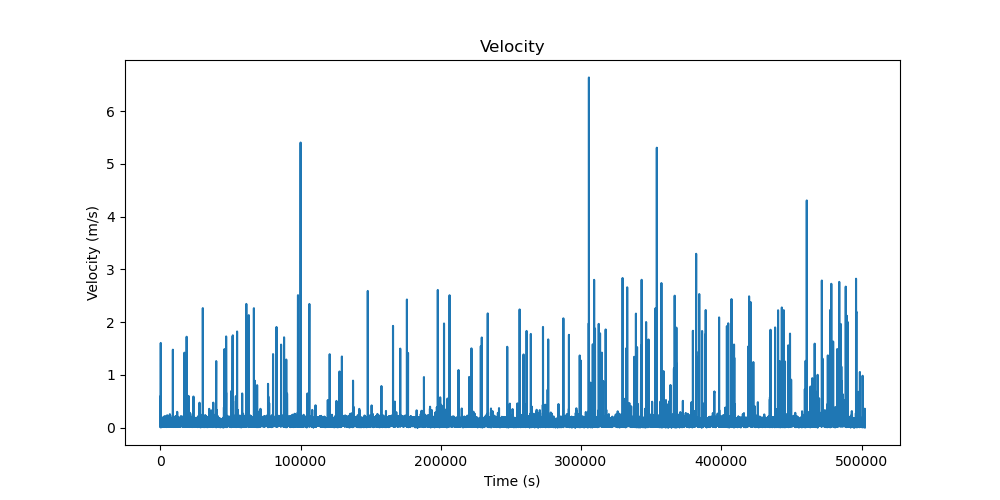

In [18]:
#  plot velocity

plt.figure(figsize=(10, 5))
plt.plot(velocity)
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity')
plt.show()


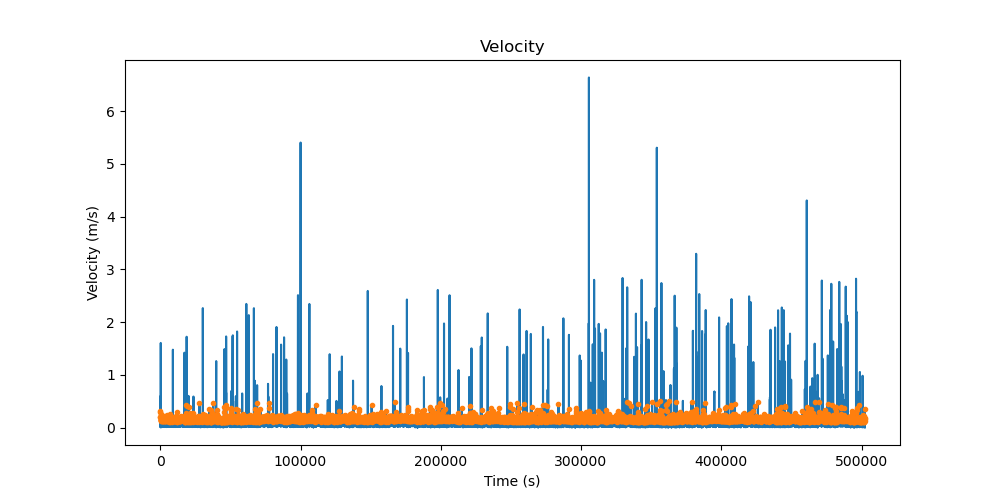

In [19]:
#  find peaks
fHz= 100
height= (0.1, 0.5)
frames_btw_2bouts = round(fHz/5)
bout_width = round(fHz/100)
prominence = 0.08

peaks, _ = find_peaks(velocity, height=height, distance=frames_btw_2bouts, width=bout_width, prominence=prominence)

plt.figure(figsize=(10, 5))
plt.plot(velocity)
plt.plot(peaks, velocity[peaks], ".")
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity')
plt.show()


In [20]:
#  take angle at the peak
angles_at_peaks = angles[peaks]

# Normalize angles between -π and π
angles_at_peaks_normalized = np.mod(angles_at_peaks, 2 * np.pi) - np.pi

# Unwrap normalized angles
angles_at_peaks_unwrapped = np.unwrap(angles_at_peaks_normalized)

# Calculate differences between consecutive unwrapped angles
angles_at_peaks_diff = np.diff(angles_at_peaks_unwrapped)

# Apply modulo arithmetic to ensure range between -π and π
angles_at_peaks_diff = np.mod(angles_at_peaks_diff + np.pi, 2 * np.pi) - np.pi



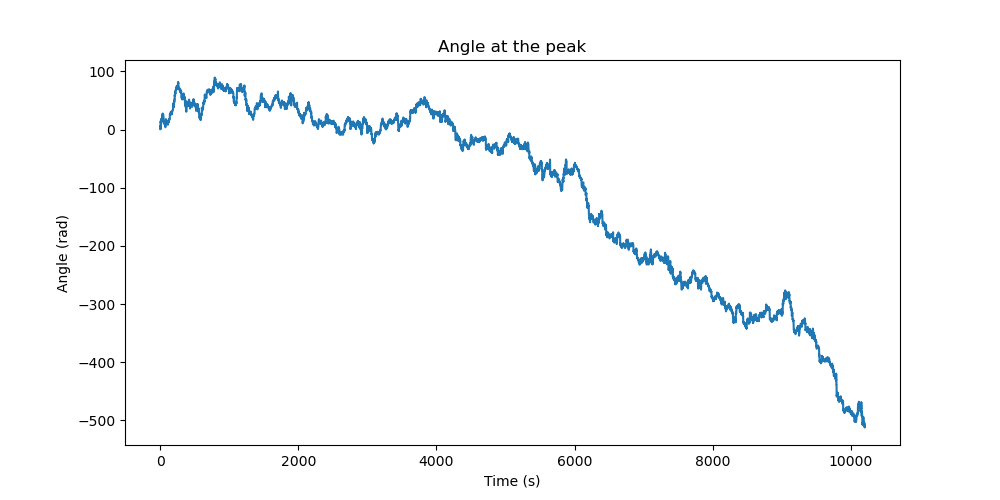

In [21]:
#  plot angle at the peak
plt.figure(figsize=(10, 5))
plt.plot(angles_at_peaks)
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Angle at the peak')
plt.show()

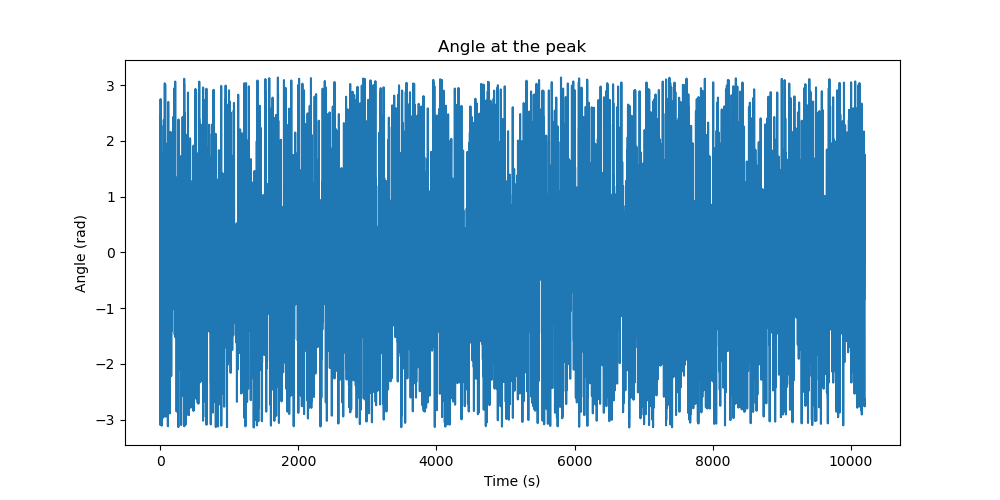

In [22]:

# make it in arn

#  plot the difference between two consecutive angles
plt.figure(figsize=(10, 5))
plt.plot(angles_at_peaks_diff)
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Angle at the peak')
plt.show()
    

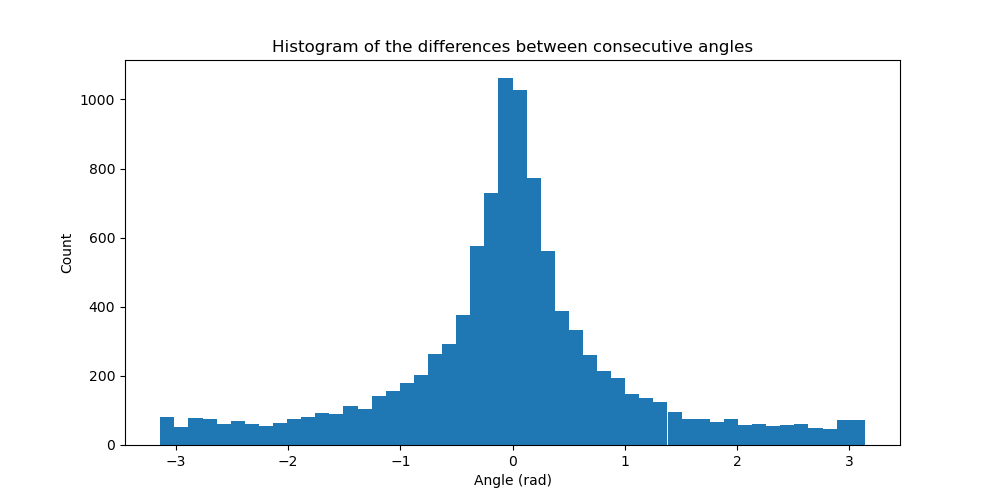

In [23]:
#  Draw a histogram of the differences between consecutive angles
plt.figure(figsize=(10, 5))
plt.hist(angles_at_peaks_diff, bins=50)
plt.xlabel('Angle (rad)')
plt.ylabel('Count')
plt.title('Histogram of the differences between consecutive angles')
plt.show()


In [24]:
#  calculate the number of clockwise and counterclockwise turns
counterclockwise_turns = np.sum(angles_at_peaks_diff > 0)
clockwise_turns = np.sum(angles_at_peaks_diff < 0)

print('Number of counterclockwise turns: {}'.format(counterclockwise_turns))
print('Number of clockwise turns: {}'.format(clockwise_turns))

Number of counterclockwise turns: 5058
Number of clockwise turns: 5146


In [25]:
#  calcculate probability of clockwise and counterclockwise turns
probability_counterclockwise_turns = counterclockwise_turns / (counterclockwise_turns + clockwise_turns)
probability_clockwise_turns = clockwise_turns / (counterclockwise_turns + clockwise_turns)

print('Probability of counterclockwise turns: {}'.format(probability_counterclockwise_turns))
print('Probability of clockwise turns: {}'.format(probability_clockwise_turns))


Probability of counterclockwise turns: 0.495687965503724
Probability of clockwise turns: 0.5043120344962759


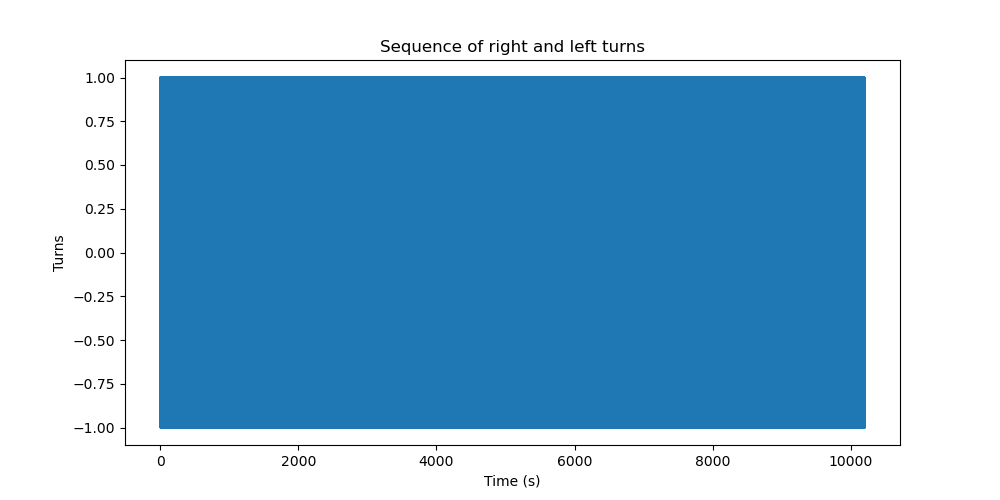

In [26]:
#  get sequence of right and left turns as 1 and -1
turns = np.sign(angles_at_peaks_diff)

#  plot the sequence of right and left turns

plt.figure(figsize=(10, 5)) 
plt.plot(turns)
plt.xlabel('Time (s)')
plt.ylabel('Turns')
plt.title('Sequence of right and left turns')
plt.show()


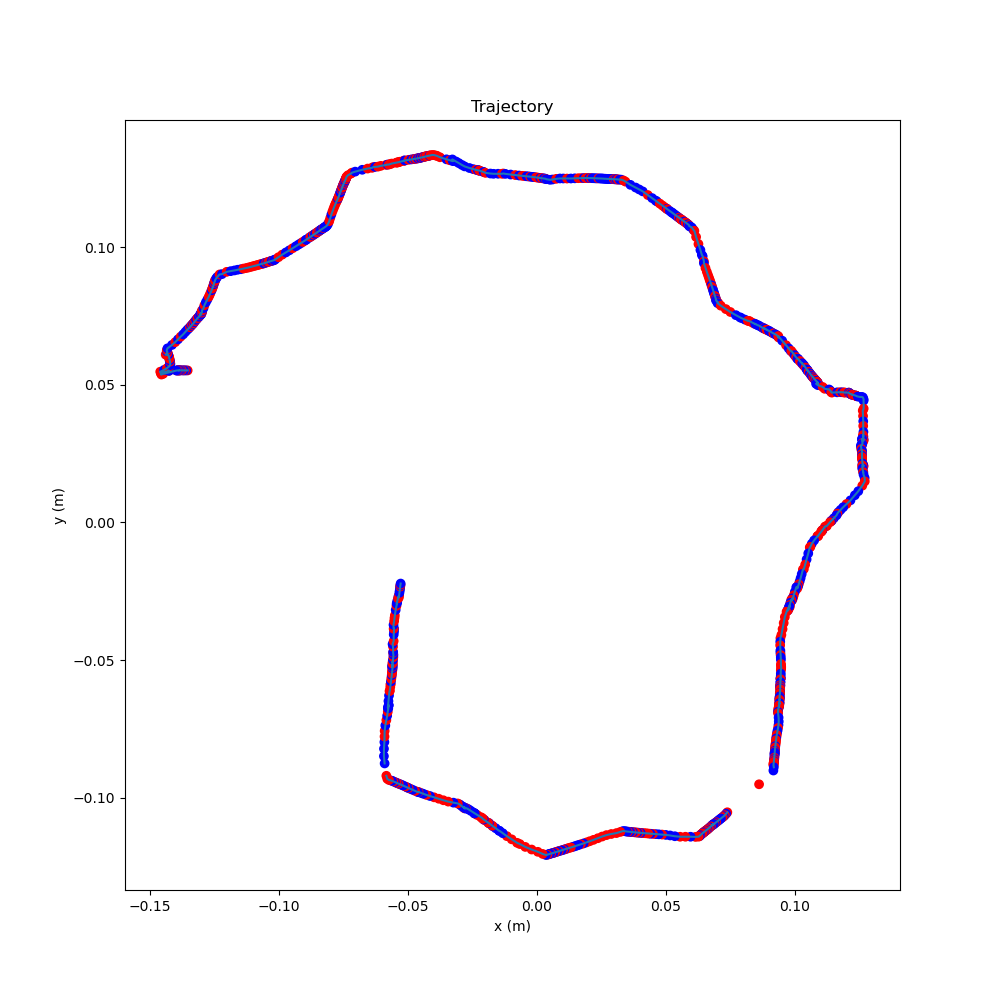

In [27]:
#  plot trajectory for 1000 frames with right and left turns as red and blue
plt.figure(figsize=(10, 10))
plt.plot(ddf.fishx[3000:4000], ddf.fishy[3000:4000])
plt.scatter(ddf.fishx[3000:4000], ddf.fishy[3000:4000], c=turns[3000:4000], cmap='bwr')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Trajectory')
plt.show()


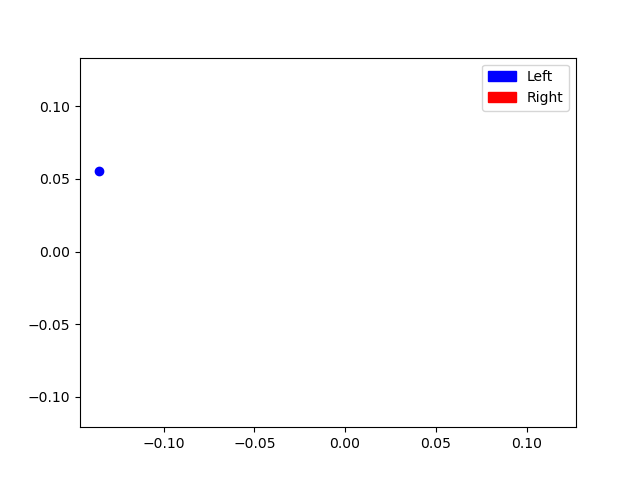

In [28]:
import matplotlib.animation as animation
import matplotlib.patches as mpatches

fig, ax = plt.subplots()

x = ddf.fishx[3000:4000].reset_index(drop=True)
y = ddf.fishy[3000:4000].reset_index(drop=True)
z= ddf.fishz[3000:4000].reset_index(drop=True)
t = turns[3000:4000] # Assuming that turns is already set and of the same length

sc = ax.scatter(x[0], y[0], c=t[0], cmap='bwr') # 'bwr' colormap for binary color
plt.xlim(min(x), max(x))
plt.ylim(min(y), max(y))

# Create legend
left_patch = mpatches.Patch(color='blue', label='Left')
right_patch = mpatches.Patch(color='red', label='Right')
plt.legend(handles=[left_patch, right_patch])

def animate(i):
    sc.set_offsets(np.c_[x[:i+1], y[:i+1]]) # Note: Adding 1 because Python slice does not include the stop index
    sc.set_array(t[:i+1])
    return sc,

ani = animation.FuncAnimation(fig, animate, frames=len(x), interval=200, blit=True)

plt.show()




/usr/lib/python3/dist-packages/matplotlib/animation.py:887: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


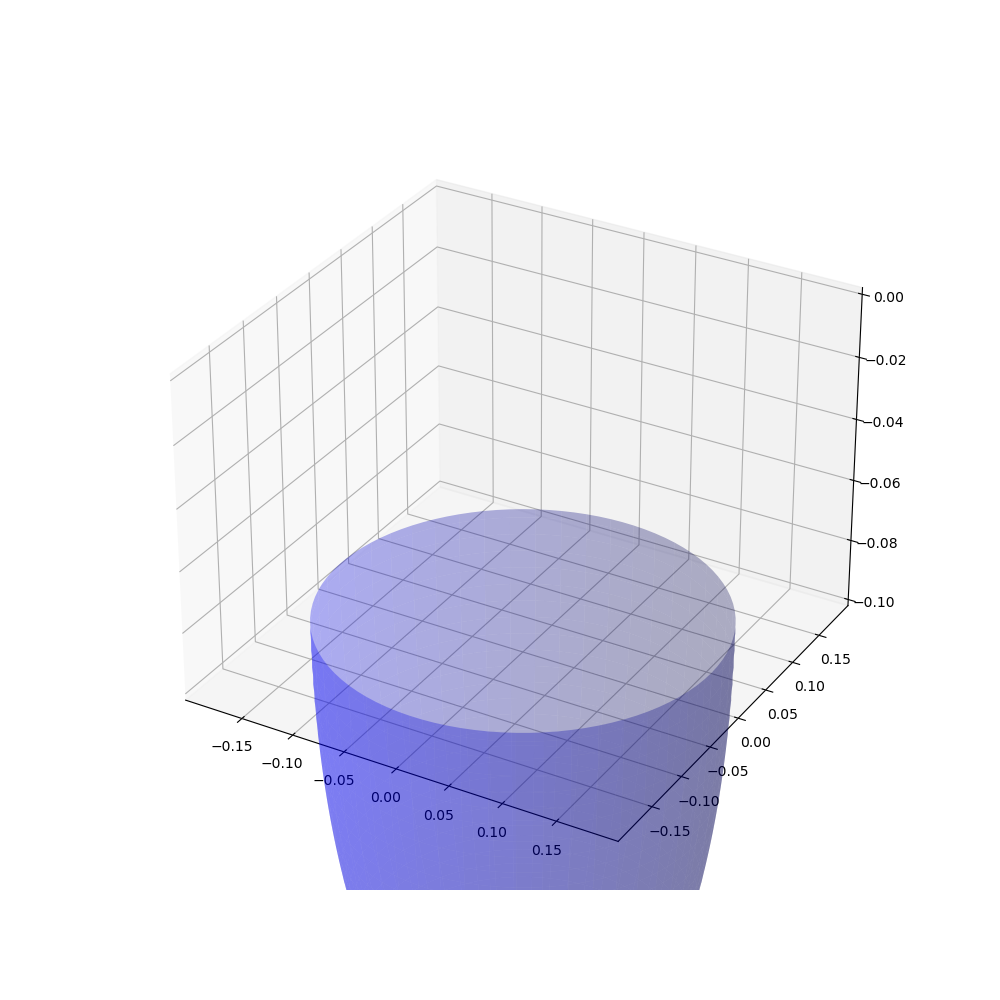

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from IPython.display import HTML

# Define the bowl dimensions
r = 0.18  # radius in meters
h = 0.09  # height in meters (height of the bowl)
shift = r - h  # the shift upward

# Define resolution and range for theta and phi
res = 100  # Increase resolution
theta_range = np.linspace(0, 2.*np.pi, res)  # azimuthal angle
phi_range = np.linspace(0, np.pi/2, res)  # polar angle

# Define the x, y, and z coordinates for the bowl
theta, phi = np.meshgrid(theta_range, phi_range)  
x = r * np.sin(phi) * np.cos(theta)
y = r * np.sin(phi) * np.sin(theta)
z = shift + r * np.cos(phi)

# Create the 3D figure
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# Plot the bowl
ax.plot_surface(x, y, -z, color='b', alpha=0.3)  # The negative sign to make bowl face downwards

# Setting equal aspect ratio for all axes
# ax.set_box_aspect([1,1,1])

# Setting z axis limits
ax.set_zlim(-0.1, 0)

# Create animation
line, = ax.plot([], [], [], lw=2)

def init():
    ax.scatter(ddf.fishx[3000:4000], ddf.fishy[3000:4000], ddf.fishz[3000:4000], c=turns[3000:4000], cmap='bwr')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_zlabel('z (m)')
    return line,

def animate(i):
    line.set_data(ddf.fishx[3000:3000+i], ddf.fishy[3000:3000+i])
    line.set_3d_properties(ddf.fishz[3000:3000+i])
    return line,

ani = animation.FuncAnimation(fig, animate, init_func=init, frames=1000, interval=200, blit=True)

# Convert the animation to HTML5 video
plt.show()


In [30]:
#  replace all -1 with 0 in turns
turns[turns == -1] = 0
print(turns)


[1. 1. 1. ... 0. 0. 0.]


In [31]:
#  calculate autocorrelation of the sequence of right and left turns
autocorrelation = np.correlate(turns, turns, mode='full')

# #  plot autocorrelation
# plt.figure(figsize=(10, 5))
# plt.plot(autocorrelation)
# plt.xlabel('Time (s)')
# plt.ylabel('Autocorrelation')
# plt.title('Autocorrelation of the sequence of right and left turns')
# plt.show()



In [32]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]

autocorr_vals = autocorr(turns)

# plt.figure(figsize=(10, 5))
# plt.plot(autocorr_vals)
# plt.title('Autocorrelation of turns')
# plt.xlabel('Lag')
# plt.ylabel('Autocorrelation')
# plt.show()


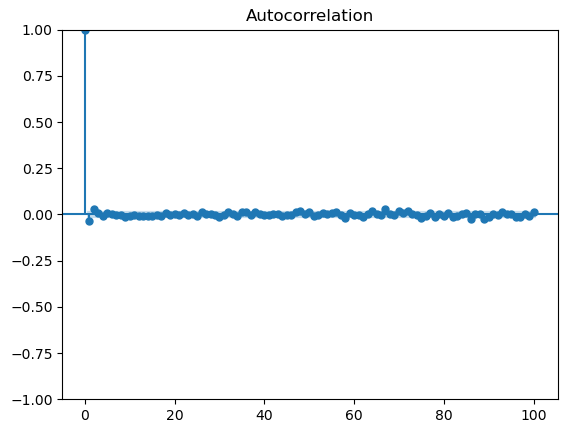

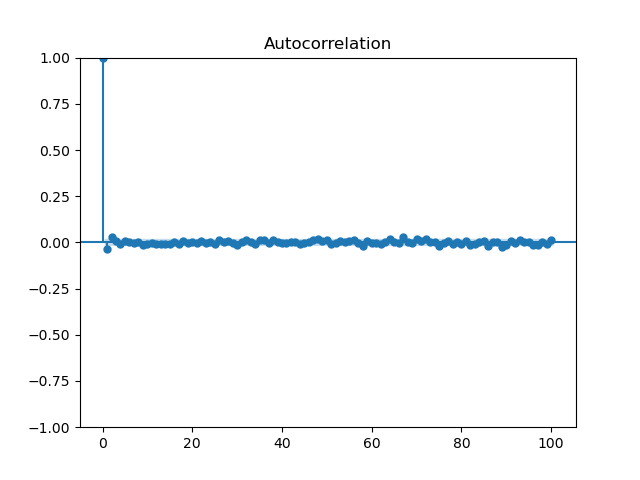

In [33]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(turns, lags=100)
# plt.show()

In [34]:
def streak_lengths(turns):
    if len(turns) == 0:
        return np.array([])  # return empty array for empty input

    streaks = []
    current_streak = 1  # start with a streak of 1

    for i in range(1, len(turns)):
        if turns[i] == turns[i - 1]:  # if current turn is same as previous
            current_streak += 1  # increment streak count
        else:  # if current turn is different
            streaks.append(current_streak)  # add the streak to the list
            current_streak = 1  # reset streak count

    streaks.append(current_streak)  # add the last streak
    return np.array(streaks)

In [35]:
turns = np.array(turns)

In [36]:
streaks = streak_lengths(turns)

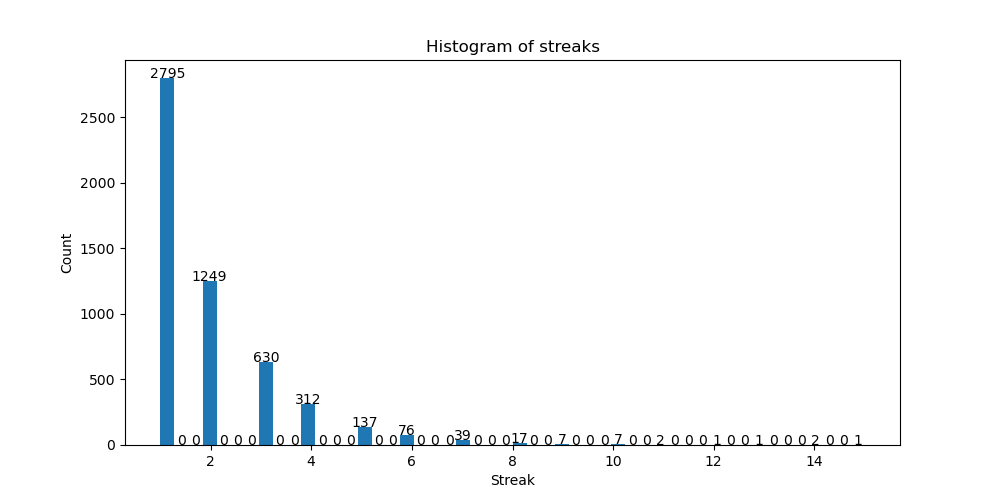

In [37]:
# #  plot histogram of streaks
# plt.figure(figsize=(10, 5))
# plt.hist(streaks, bins=50)
# plt.xlabel('Streak')
# plt.ylabel('Count')
# plt.title('Histogram of streaks')
# plt.show()
#  plot histogram of streaks
plt.figure(figsize=(10, 5))
n, bins, patches = plt.hist(streaks, bins=50)

# Iterate over each patch (or rectangle)
for count, patch in zip(n, patches):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width()/2, height + 0.05, str(int(count)), 
             ha='center', color='black')

plt.xlabel('Streak')
plt.ylabel('Count')
plt.title('Histogram of streaks')
plt.show()



In [38]:
turnp= turns

In [39]:
#  replace 0 with -1 in turnp
turnp[turnp == 0] = -1
turnp[0:200]

array([ 1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,
        1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1., -1., -1., -1., -1.,
        1.,  1.,  1., -1., -1., -1., -1.,  1., -1., -1., -1.,  1., -1.,
       -1.,  1.,  1., -1.,  1., -1.,  1., -1., -1., -1.,  1.,  1.,  1.,
        1.,  1., -1., -1., -1., -1.,  1., -1.,  1., -1.,  1., -1., -1.,
        1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1.,  1., -1.,
        1.,  1., -1., -1.,  1., -1., -1., -1.,  1., -1., -1.,  1.,  1.,
        1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1.,  1.,  1., -1.,
       -1., -1., -1.,  1., -1., -1., -1., -1.,  1.,  1.,  1., -1.,  1.,
       -1.,  1., -1.,  1.,  1.,  1., -1., -1., -1., -1.,  1.,  1., -1.,
        1., -1., -1., -1., -1., -1.,  1.,  1., -1., -1., -1.,  1., -1.,
       -1.,  1., -1.,  1., -1.,  1.,  1., -1., -1.,  1., -1., -1.,  1.,
       -1.,  1., -1., -1., -1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  1.,
       -1.,  1.,  1., -1., -1.,  1., -1.,  1.,  1., -1.,  1.,  1

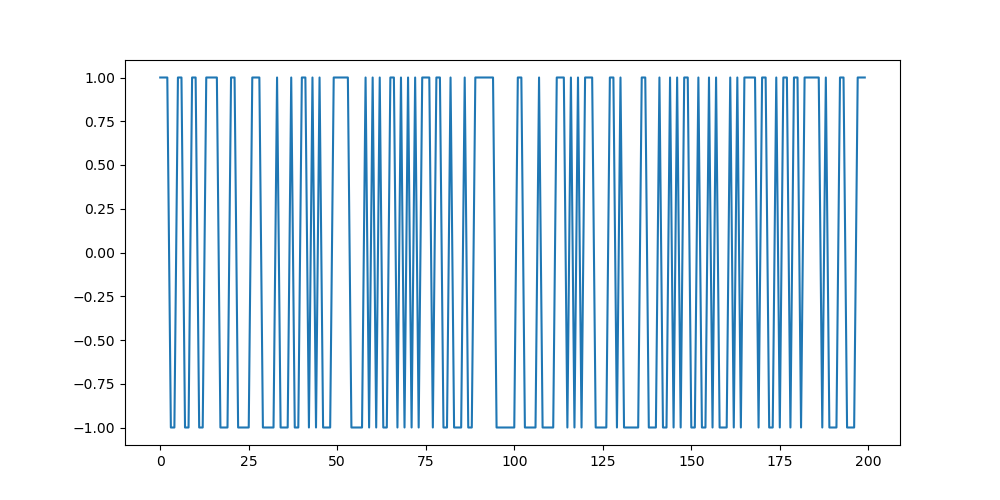

In [40]:
# plot turnp[0:200] on a figure with 1 as red and -1 as blue
plt.figure(figsize=(10, 5))
plt.plot(turnp[0:200])
plt.show()                                                                                                     

ValueError: 'c' argument has 10204 elements, which is inconsistent with 'x' and 'y' with size 502254.

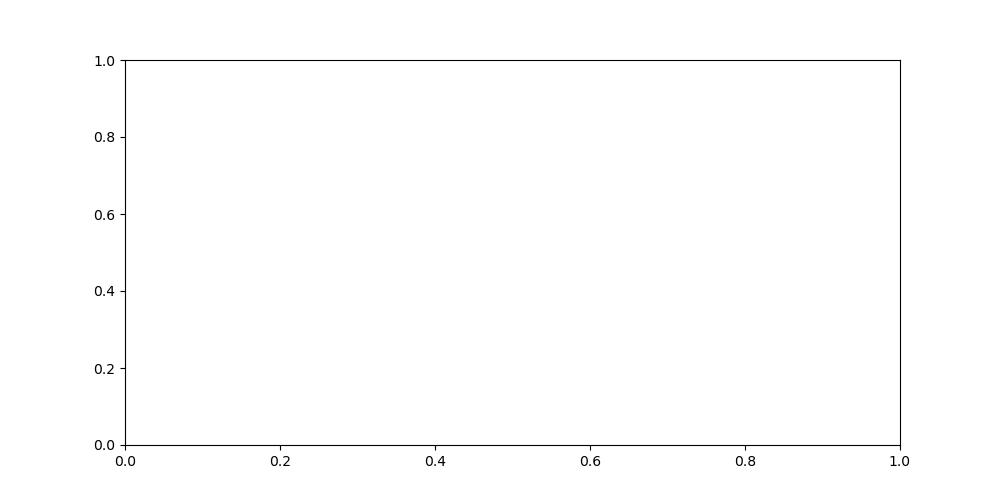

In [41]:
#  plot angle at the peak over time in animation clockwise as red and counterclockwise as blue
plt.figure(figsize=(10, 5))
plt.scatter(ddf.fishx, ddf.fishy, c=turns, cmap='bwr')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Trajectory')
plt.show()